# Wannierization using Wannier90

DFTK features an interface with the program
[Wannier90](http://www.wannier.org/),
in order to compute maximally-localized Wannier functions (MLWFs)
from an initial self consistent field calculation.
All processes are handled by calling the routine `run_wannier90`.

!!! warning "No guarantees on Wannier90 interface"
    This code is at an early stage and has so far not been fully tested.
    Bugs are likely and we welcome issues in case you find any!

This example shows how to obtain the MLWFs corresponding
to the first five bands of graphene. Since the bands 2 to 11 are entangled,
15 bands are first computed to obtain 5 MLWFs by a disantanglement procedure.

In [1]:
using DFTK
using Unitful
using UnitfulAtomic

d = 10u"Å"
a = 2.641u"Å"  # Graphene Lattice constant
lattice = [a  -a/2    0;
           0  √3*a/2  0;
           0     0    d]

C = ElementPsp(:C, psp=load_psp("hgh/pbe/c-q4"))
atoms     = [C, C]
positions = [[0.0, 0.0, 0.0], [1//3, 2//3, 0.0]]
model  = model_PBE(lattice, atoms, positions)
basis  = PlaneWaveBasis(model; Ecut=15, kgrid=[5, 5, 1])
scfres = self_consistent_field(basis; n_bands=15, tol=1e-8);

n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -11.14941634688                   -0.67    7.0
  2   -11.15007255683       -3.18       -1.40    1.0
  3   -11.15010797560       -4.45       -2.76    4.6
  4   -11.15010941907       -5.84       -3.35    6.0
  5   -11.15010943311       -7.85       -4.18    3.2
  6   -11.15010943375       -9.20       -5.14    4.2


Plot bandstructure of the system

Computing bands along kpath:
       Γ -> M -> K -> Γ -> A -> L -> H -> A  and  L -> M  and  H -> K
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:16


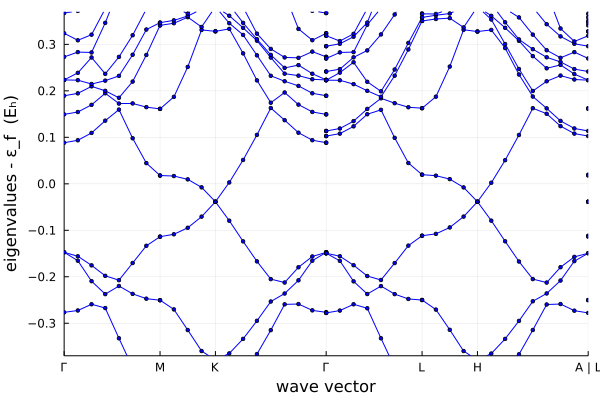

In [2]:
plot_bandstructure(scfres; kline_density=10)

Now we use the `run_wannier90` routine to generate all files needed by
wannier90 and to perform the wannierization procedure.
In Wannier90's convention, all files are named with the same prefix and only differ by
their extensions. By default all generated input and output files are stored
in the subfolder "wannier90" under the prefix "wannier" (i.e. "wannier90/wannier.win",
"wannier90/wannier.wout", etc.). A different file prefix can be given with the
keyword argument `fileprefix` as shown below.

We now solve for 5 MLWF using wannier90:

In [3]:
using wannier90_jll  # Needed to make run_wannier90 available
run_wannier90(scfres;
              fileprefix="wannier/graphene",
              n_wannier=5,
              num_print_cycles=25,
              num_iter=200,
              #
              dis_win_max=19.0,
              dis_froz_max=0.1,
              dis_num_iter=300,
              dis_mix_ratio=1.0,
              #
              wannier_plot=true,
              wannier_plot_format="cube",
              wannier_plot_supercell=5,
              write_xyz=true,
              translate_home_cell=true,
             );

As can be observed standard optional arguments for the disentanglement
can be passed directly to `run_wannier90` as keyword arguments.

delete temporary files:

In [4]:
rm("wannier", recursive=true)